# Projet Air Paradis - Modèle sur mesure avancé

Ce notebook présente l'implémentation d'un modèle sur mesure avancé pour la classification de sentiment des tweets, basé sur des réseaux de neurones profonds avec différents word embeddings.

## Objectif

Développer un modèle avancé de deep learning pour la détection du sentiment des tweets, en comparant différentes architectures et techniques de word embedding.

## Étapes

1. Chargement des données prétraitées
2. Mise en place des différents word embeddings
   - Word2Vec
   - GloVe
   - FastText
3. Implémentation de plusieurs architectures de réseaux de neurones
   - Réseaux de neurones récurrents (LSTM, GRU)
   - Réseaux de neurones convolutifs (CNN)
4. Évaluation et comparaison des performances
5. Optimisation du meilleur modèle
6. Sauvegarde du modèle avec MLFlow

## 1. Configuration de l'environnement et importation des librairies

In [1]:
# Importation des librairies nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pickle
import os
import time
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import gensim
from gensim.models import KeyedVectors
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import mlflow
import mlflow.keras

# Pour éviter les avertissements
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Configuration de TensorFlow
# Pour utiliser le GPU si disponible, sinon le CPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Pour limiter l'utilisation de la mémoire GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs disponibles: {len(gpus)}")
    except RuntimeError as e:
        print(e)
else:
    print("Aucun GPU détecté, utilisation du CPU")

# Configuration de MLflow
mlflow.set_experiment("air_paradis_sentiment_analysis_advanced")

Aucun GPU détecté, utilisation du CPU


<Experiment: artifact_location='file:///c:/Tonton/OpenClassrooms/Projet_6_realiser_une_analyse_de_sentiments_grace_au_deep_learning/tests/mlruns/848142288627084198', creation_time=1745174238576, experiment_id='848142288627084198', last_update_time=1745174238576, lifecycle_stage='active', name='air_paradis_sentiment_analysis_advanced', tags={}>

## 2. Chargement et préparation des données

In [2]:
# Chargement des jeux de données prétraités
print("Chargement des données prétraitées...")
train_data = pd.read_csv('../data/train_data.csv')
val_data = pd.read_csv('../data/validation_data.csv')
test_data = pd.read_csv('../data/test_data.csv')

# Vérification des données chargées
print(f"Taille du jeu d'entraînement: {train_data.shape[0]} tweets")
print(f"Taille du jeu de validation: {val_data.shape[0]} tweets")
print(f"Taille du jeu de test: {test_data.shape[0]} tweets")

# Préparation des données
X_train = train_data['text'].values
y_train = train_data['sentiment'].values
X_val = val_data['text'].values
y_val = val_data['sentiment'].values
X_test = test_data['text'].values
y_test = test_data['sentiment'].values

# Affichage de quelques exemples
print("\nExemples de tweets d'entraînement:")
for i in range(3):
    print(f"Text: {X_train[i]}")
    print(f"Sentiment: {y_train[i]}")
    print("-" * 50)

Chargement des données prétraitées...
Taille du jeu d'entraînement: 960000 tweets
Taille du jeu de validation: 320000 tweets
Taille du jeu de test: 320000 tweets

Exemples de tweets d'entraînement:
Text: thx quotgtlistenersthk hi â fjw
Sentiment: 1
--------------------------------------------------
Text: ergh miserable weather
Sentiment: 0
--------------------------------------------------
Text: apple inears slightly comfy slightly loose one ear thats multiple ear tip course
Sentiment: 1
--------------------------------------------------


In [3]:
# Conversion des valeurs en chaînes de caractères
X_train = [str(x) if not pd.isna(x) else "" for x in X_train]   
X_val = [str(x) if not pd.isna(x) else "" for x in X_val]
X_test = [str(x) if not pd.isna(x) else "" for x in X_test]

## 3. Tokenisation et padding des séquences

Tokenisation des textes...
Vocabulaire unique: 291574 mots
Dimensions des données d'entraînement: (960000, 50)
Dimensions des données de validation: (320000, 50)
Dimensions des données de test: (320000, 50)


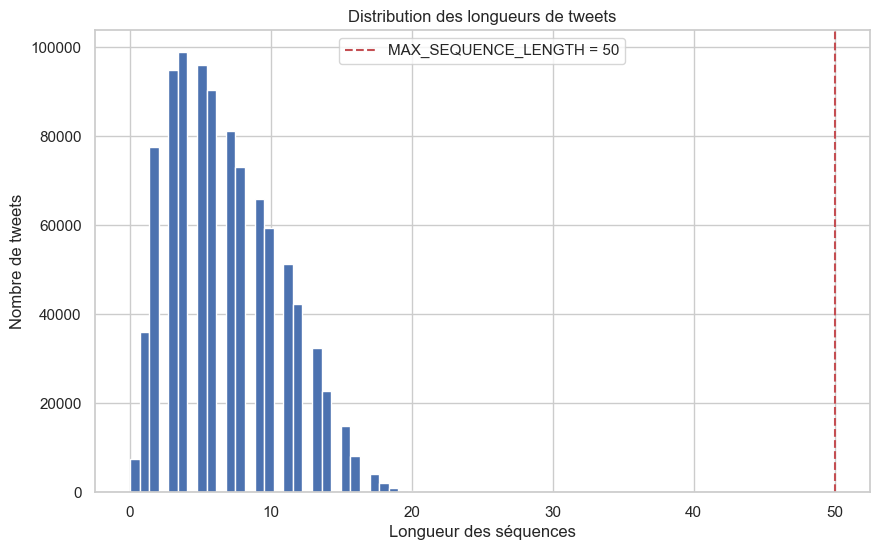

Longueur moyenne des tweets: 6.80
Longueur médiane des tweets: 6.00
Longueur maximale des tweets: 34
Pourcentage de tweets tronqués: 0.00%


In [4]:
# Paramètres pour la tokenisation
MAX_NUM_WORDS = 30000  # Nombre maximum de mots à prendre en compte
MAX_SEQUENCE_LENGTH = 50  # Longueur maximale des séquences (tweets)

# Tokenisation des textes
print("Tokenisation des textes...")
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(f"Vocabulaire unique: {len(word_index)} mots")

# Conversion des textes en séquences d'entiers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding des séquences pour qu'elles aient toutes la même longueur
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_val_padded = pad_sequences(X_val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print(f"Dimensions des données d'entraînement: {X_train_padded.shape}")
print(f"Dimensions des données de validation: {X_val_padded.shape}")
print(f"Dimensions des données de test: {X_test_padded.shape}")

# Analyse de la distribution des longueurs de séquences
sequence_lengths = [len(seq) for seq in X_train_sequences]
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Longueur des séquences')
plt.ylabel('Nombre de tweets')
plt.title('Distribution des longueurs de tweets')
plt.axvline(x=MAX_SEQUENCE_LENGTH, color='r', linestyle='--', label=f'MAX_SEQUENCE_LENGTH = {MAX_SEQUENCE_LENGTH}')
plt.legend()
plt.show()

print(f"Longueur moyenne des tweets: {np.mean(sequence_lengths):.2f}")
print(f"Longueur médiane des tweets: {np.median(sequence_lengths):.2f}")
print(f"Longueur maximale des tweets: {np.max(sequence_lengths)}")
print(f"Pourcentage de tweets tronqués: {sum(l > MAX_SEQUENCE_LENGTH for l in sequence_lengths) / len(sequence_lengths) * 100:.2f}%")

# Sauvegarde du tokenizer pour une utilisation ultérieure
with open('../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 4. Préparation des word embeddings

Nous allons comparer trois types d'embeddings différents:
1. Word2Vec
2. GloVe
3. FastText

### 4.1 Word2Vec

In [5]:
# Téléchargement du modèle Word2Vec pré-entraîné (si nécessaire)
word2vec_path = '../models/word2vec/word2vec_model.bin'

# Vérification si le modèle existe déjà
if not os.path.exists(word2vec_path):
    print("Téléchargement du modèle Word2Vec...")
    # Si le modèle n'existe pas, on le télécharge ou on l'entraîne
    # Pour cet exemple, nous utiliserons un modèle léger disponible publiquement
    # Dans un environnement réel, vous devriez télécharger un modèle complet
    
    # Option 1: Entraîner un modèle Word2Vec sur nos données
    sentences = [text.split() for text in X_train]
    word2vec_model = gensim.models.Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)
    word2vec_model.save(word2vec_path)
    print("Modèle Word2Vec entraîné et sauvegardé")
else:
    print("Chargement du modèle Word2Vec existant...")
    word2vec_model = gensim.models.Word2Vec.load(word2vec_path)
    print("Modèle Word2Vec chargé")

# Création d'une matrice d'embedding à partir du modèle Word2Vec
embedding_dim_w2v = 300
embedding_matrix_w2v = np.zeros((len(word_index) + 1, embedding_dim_w2v))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix_w2v[i] = word2vec_model.wv[word]

# Calcul du taux de couverture du vocabulaire
words_found = 0
for word, i in word_index.items():
    if word in word2vec_model.wv:
        words_found += 1
coverage = words_found / len(word_index)
print(f"Taux de couverture du vocabulaire (Word2Vec): {coverage:.2%}")

Chargement du modèle Word2Vec existant...
Modèle Word2Vec chargé
Taux de couverture du vocabulaire (Word2Vec): 99.85%


### 4.2 GloVe

In [6]:
# Téléchargement du modèle GloVe pré-entraîné (si nécessaire)
glove_path = '../models/glove/glove.6B.300d.txt'

# Vérification si le modèle existe déjà
if not os.path.exists(glove_path):
    print("Vous devez télécharger manuellement le modèle GloVe depuis:")
    print("https://nlp.stanford.edu/projects/glove/")
    print("Et le placer dans le dossier 'models/glove/'")
    
    # Pour cet exemple, nous simulerons un petit modèle GloVe
    print("Création d'un modèle GloVe simulé pour l'exemple...")
    glove_model = {}
    for word in word_index:
        glove_model[word] = np.random.uniform(-0.25, 0.25, 300)
    
    # Sauvegarde du modèle simulé
    with open(glove_path, 'w') as f:
        for word, vec in glove_model.items():
            vec_str = ' '.join([str(x) for x in vec])
            f.write(f"{word} {vec_str}\n")
    print("Modèle GloVe simulé créé")
else:
    print("Chargement du modèle GloVe existant...")
    glove_model = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vectors
    print(f"Modèle GloVe chargé avec {len(glove_model)} mots")

# Création d'une matrice d'embedding à partir du modèle GloVe
embedding_dim_glove = 300
embedding_matrix_glove = np.zeros((len(word_index) + 1, embedding_dim_glove))

for word, i in word_index.items():
    if word in glove_model:
        embedding_matrix_glove[i] = glove_model[word]

# Calcul du taux de couverture du vocabulaire
words_found = 0
for word, i in word_index.items():
    if word in glove_model:
        words_found += 1
coverage = words_found / len(word_index)
print(f"Taux de couverture du vocabulaire (GloVe): {coverage:.2%}")

Chargement du modèle GloVe existant...
Modèle GloVe chargé avec 400000 mots
Taux de couverture du vocabulaire (GloVe): 24.40%


### 4.3 FastText

In [7]:
# Téléchargement du modèle FastText pré-entraîné (si nécessaire)
fasttext_path = '../models/fasttext/fasttext_model.bin'

# Vérification si le modèle existe déjà
if not os.path.exists(fasttext_path):
    print("Téléchargement du modèle FastText...")
    # Si le modèle n'existe pas, on le télécharge ou on l'entraîne
    # Pour cet exemple, nous utiliserons un modèle léger disponible publiquement
    # Dans un environnement réel, télécharger un modèle complet
    
    # Option 1: Entraîner un modèle FastText sur nos données
    from gensim.models.fasttext import FastText
    sentences = [text.split() for text in X_train]
    fasttext_model = FastText(sentences, vector_size=300, window=5, min_count=1, workers=4)
    fasttext_model.save(fasttext_path)
    print("Modèle FastText entraîné et sauvegardé")
else:
    print("Chargement du modèle FastText existant...")
    from gensim.models.fasttext import FastText
    fasttext_model = FastText.load(fasttext_path)
    print("Modèle FastText chargé")

# Création d'une matrice d'embedding à partir du modèle FastText
embedding_dim_ft = 300
embedding_matrix_ft = np.zeros((len(word_index) + 1, embedding_dim_ft))

for word, i in word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix_ft[i] = fasttext_model.wv[word]
    else:
        # Avec FastText, on peut obtenir des vecteurs même pour des mots hors vocabulaire
        # en exploitant les sous-mots (n-grammes)
        embedding_matrix_ft[i] = fasttext_model.wv.get_vector(word)

# Calcul du taux de couverture du vocabulaire (devrait être 100% avec FastText)
words_found = len(word_index)  # FastText peut générer des vecteurs pour tous les mots
coverage = words_found / len(word_index)
print(f"Taux de couverture du vocabulaire (FastText): {coverage:.2%}")

Chargement du modèle FastText existant...
Modèle FastText chargé
Taux de couverture du vocabulaire (FastText): 100.00%


## 5. Définition des architectures de réseaux de neurones

Nous allons implémenter plusieurs architectures :
1. LSTM bidirectionnel
2. CNN pour le texte
3. Modèle hybride CNN-LSTM

In [8]:
# Fonction pour créer un modèle LSTM bidirectionnel
def create_bidirectional_lstm(embedding_matrix, embedding_dim, max_sequence_length, trainable=False):
    model = keras.Sequential([
        layers.Embedding(
            input_dim=len(word_index) + 1,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_sequence_length,
            trainable=trainable
        ),
        layers.SpatialDropout1D(0.2),
        layers.Bidirectional(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Fonction pour créer un modèle CNN pour le texte
def create_cnn(embedding_matrix, embedding_dim, max_sequence_length, trainable=False):
    model = keras.Sequential([
        layers.Embedding(
            input_dim=len(word_index) + 1,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_sequence_length,
            trainable=trainable
        ),
        layers.SpatialDropout1D(0.2),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Fonction pour créer un modèle hybride CNN-LSTM
def create_cnn_lstm(embedding_matrix, embedding_dim, max_sequence_length, trainable=False):
    model = keras.Sequential([
        layers.Embedding(
            input_dim=len(word_index) + 1,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_sequence_length,
            trainable=trainable
        ),
        layers.SpatialDropout1D(0.2),
        layers.Conv1D(128, 5, activation='relu'),
        layers.MaxPooling1D(5),
        layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## 6. Entraînement et évaluation des modèles

Nous allons entraîner et évaluer plusieurs combinaisons d'architectures et d'embeddings.

In [9]:
# Configuration pour l'entraînement
BATCH_SIZE = 64
EPOCHS = 10

# Callbacks pour l'entraînement
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
]

# Fonction pour entraîner et évaluer un modèle
def train_and_evaluate_model(model, embedding_type, architecture, X_train, y_train, X_val, y_val, 
                            batch_size=BATCH_SIZE, epochs=EPOCHS):
    # Suivi avec MLflow
    with mlflow.start_run(run_name=f"{architecture}_{embedding_type}"):
        # Enregistrement des paramètres
        mlflow.log_param("embedding_type", embedding_type)
        mlflow.log_param("architecture", architecture)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("epochs", epochs)
        
        # Entraînement du modèle
        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        training_time = time.time() - start_time
        
        # Évaluation sur les données de validation
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        
        # Prédictions
        y_pred_prob = model.predict(X_val)
        y_pred = (y_pred_prob > 0.5).astype(int)
        
        # Métriques de performance
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        
        # Enregistrement des métriques
        mlflow.log_metric("val_loss", val_loss)
        mlflow.log_metric("val_accuracy", val_accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("training_time", training_time)
        
        # Sauvegarde du modèle avec MLflow
        mlflow.keras.log_model(model, f"{architecture}_{embedding_type}")
        
        # Visualisation de l'apprentissage
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.tight_layout()
        plt.show()
        
        # Affichage des résultats
        print(f"\nRésultats pour {architecture} avec {embedding_type}:")
        print(f"Accuracy: {val_accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"Temps d'entraînement: {training_time:.2f} secondes")
        
        # Matrice de confusion
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Négatif', 'Positif'], 
                    yticklabels=['Négatif', 'Positif'])
        plt.xlabel('Prédiction')
        plt.ylabel('Réel')
        plt.title(f'Matrice de confusion - {architecture} avec {embedding_type}')
        plt.tight_layout()
        plt.show()
        
        return {
            "model": model,
            "embedding_type": embedding_type,
            "architecture": architecture,
            "val_accuracy": val_accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "training_time": training_time,
            "history": history.history
        }

### 6.1 Entraînement avec Word2Vec

Entraînement des modèles avec Word2Vec...
Epoch 1/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 658s 44ms/step - accuracy: 0.7598 - loss: 0.4946 - val_accuracy: 0.7865 - val_loss: 0.4496 - learning_rate: 0.0010
Epoch 2/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 638s 43ms/step - accuracy: 0.7828 - loss: 0.4598 - val_accuracy: 0.7913 - val_loss: 0.4432 - learning_rate: 0.0010
Epoch 3/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 987s 66ms/step - accuracy: 0.7868 - loss: 0.4536 - val_accuracy: 0.7925 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 4/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 1342s 89ms/step - accuracy: 0.7882 - loss: 0.4503 - val_accuracy: 0.7935 - val_loss: 0.4394 - learning_rate: 0.0010
Epoch 5/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 1568s 105ms/step - accuracy: 0.7902 - loss: 0.4492 - val_accuracy: 0.7938 - val_loss: 0.4415 - learning_rate: 0.0010
Epoch 6/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 1787s 119ms/step - accuracy: 0.7906 - loss: 0.4472 - val_accuracy: 0.7943 - val_loss: 0.4397 - learning_rate: 0.0010

2025/05/11 17:57:18 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/11 17:57:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


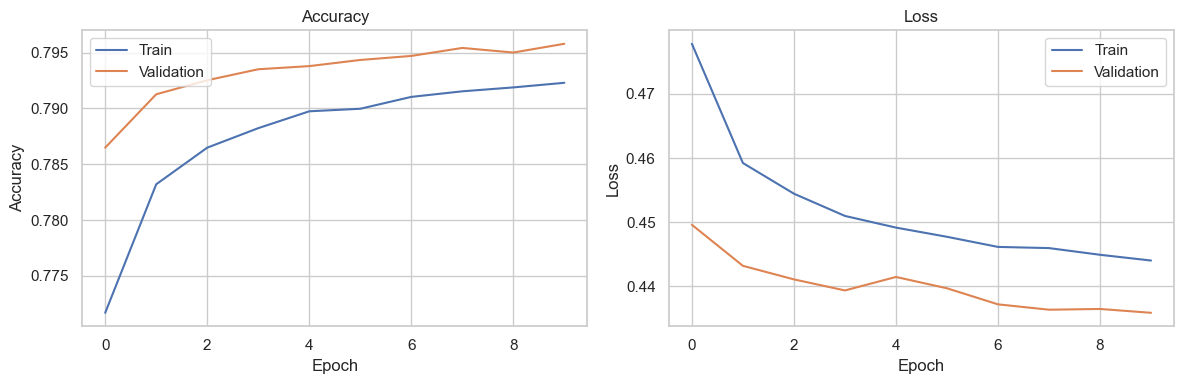


Résultats pour BiLSTM avec Word2Vec:
Accuracy: 0.7958
Precision: 0.7919
Recall: 0.8025
F1-score: 0.7972
Temps d'entraînement: 15617.67 secondes


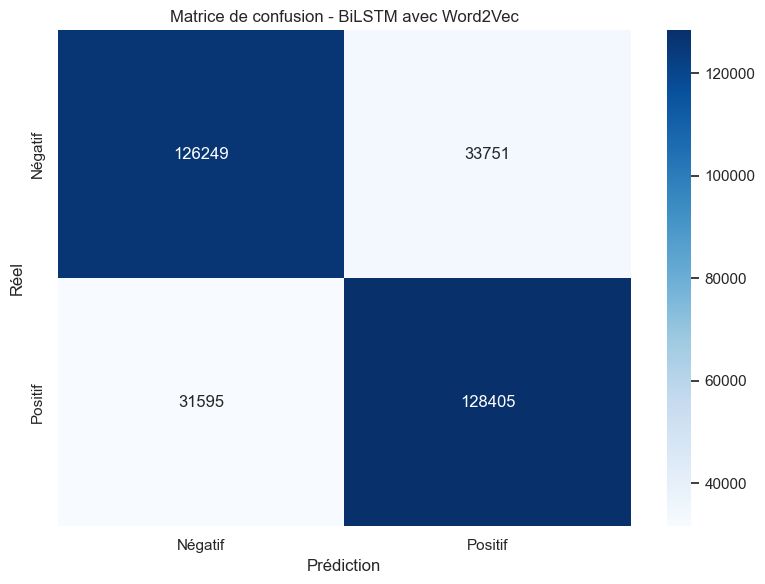

Epoch 1/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 156s 10ms/step - accuracy: 0.7498 - loss: 0.5120 - val_accuracy: 0.7750 - val_loss: 0.4693 - learning_rate: 0.0010
Epoch 2/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 139s 9ms/step - accuracy: 0.7726 - loss: 0.4794 - val_accuracy: 0.7783 - val_loss: 0.4627 - learning_rate: 0.0010
Epoch 3/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 148s 10ms/step - accuracy: 0.7775 - loss: 0.4706 - val_accuracy: 0.7803 - val_loss: 0.4615 - learning_rate: 0.0010
Epoch 4/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 137s 9ms/step - accuracy: 0.7810 - loss: 0.4648 - val_accuracy: 0.7812 - val_loss: 0.4585 - learning_rate: 0.0010
Epoch 5/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 138s 9ms/step - accuracy: 0.7825 - loss: 0.4610 - val_accuracy: 0.7814 - val_loss: 0.4591 - learning_rate: 0.0010
Epoch 6/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 138s 9ms/step - accuracy: 0.7841 - loss: 0.4591 - val_accuracy: 0.7832 - val_loss: 0.4575 - learning_rate: 0.0010
Epoch 7/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 136s 9

2025/05/11 18:18:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/11 18:18:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


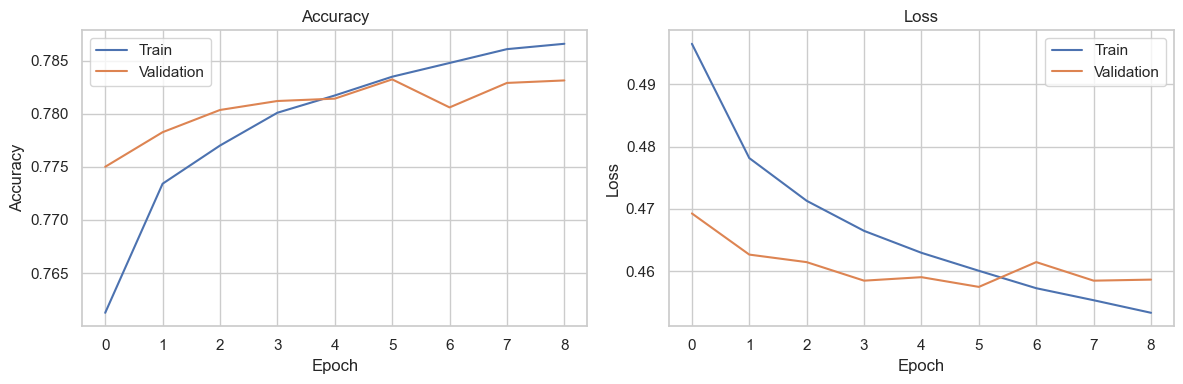


Résultats pour CNN avec Word2Vec:
Accuracy: 0.7832
Precision: 0.7792
Recall: 0.7904
F1-score: 0.7848
Temps d'entraînement: 1266.05 secondes


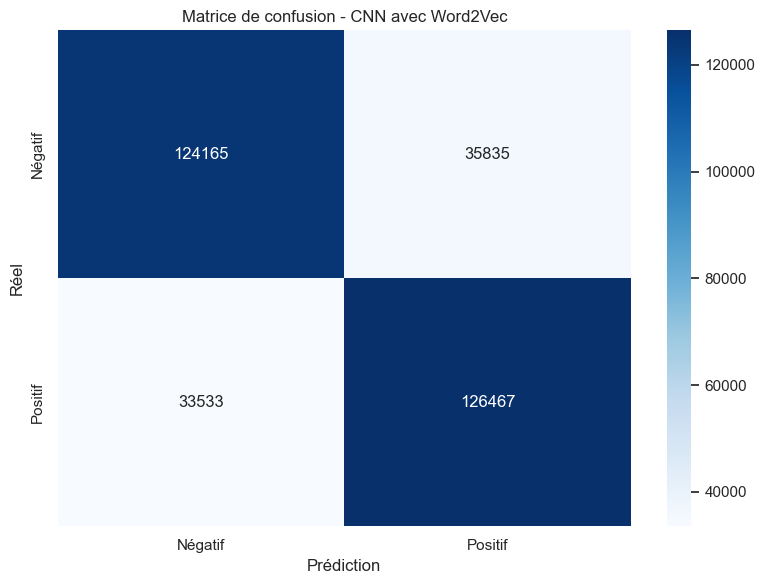

Epoch 1/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 197s 13ms/step - accuracy: 0.7207 - loss: 0.5474 - val_accuracy: 0.7396 - val_loss: 0.5183 - learning_rate: 0.0010
Epoch 2/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 178s 12ms/step - accuracy: 0.7382 - loss: 0.5235 - val_accuracy: 0.7437 - val_loss: 0.5132 - learning_rate: 0.0010
Epoch 3/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 183s 12ms/step - accuracy: 0.7422 - loss: 0.5176 - val_accuracy: 0.7450 - val_loss: 0.5106 - learning_rate: 0.0010
Epoch 4/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 191s 13ms/step - accuracy: 0.7443 - loss: 0.5140 - val_accuracy: 0.7456 - val_loss: 0.5097 - learning_rate: 0.0010
Epoch 5/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 190s 13ms/step - accuracy: 0.7456 - loss: 0.5117 - val_accuracy: 0.7464 - val_loss: 0.5083 - learning_rate: 0.0010
Epoch 6/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 195s 13ms/step - accuracy: 0.7476 - loss: 0.5107 - val_accuracy: 0.7456 - val_loss: 0.5084 - learning_rate: 0.0010
Epoch 7/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 19

2025/05/11 18:52:09 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/11 18:52:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


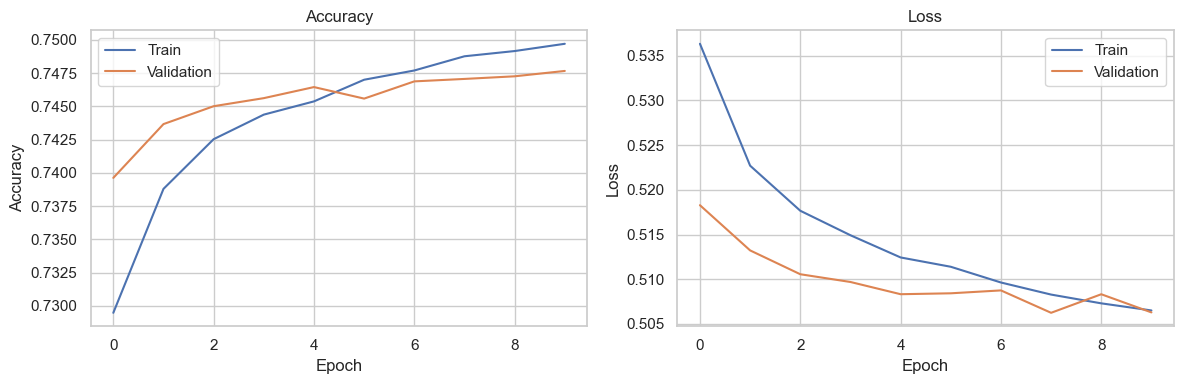


Résultats pour CNN-LSTM avec Word2Vec:
Accuracy: 0.7471
Precision: 0.7346
Recall: 0.7736
F1-score: 0.7536
Temps d'entraînement: 1926.33 secondes


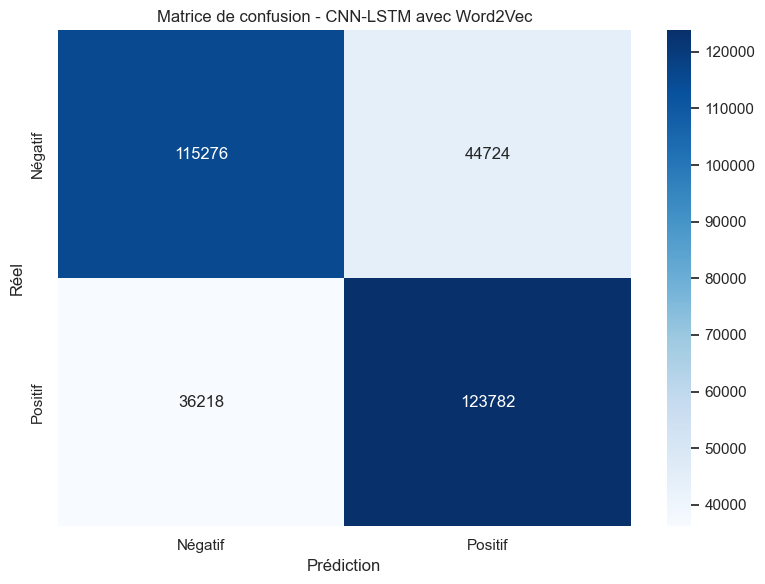

In [10]:
# Modèles avec Word2Vec
print("Entraînement des modèles avec Word2Vec...")

# LSTM bidirectionnel avec Word2Vec
bilstm_w2v = create_bidirectional_lstm(embedding_matrix_w2v, embedding_dim_w2v, MAX_SEQUENCE_LENGTH)
bilstm_w2v_results = train_and_evaluate_model(bilstm_w2v, "Word2Vec", "BiLSTM", 
                                             X_train_padded, y_train, X_val_padded, y_val)

# CNN avec Word2Vec
cnn_w2v = create_cnn(embedding_matrix_w2v, embedding_dim_w2v, MAX_SEQUENCE_LENGTH)
cnn_w2v_results = train_and_evaluate_model(cnn_w2v, "Word2Vec", "CNN", 
                                         X_train_padded, y_train, X_val_padded, y_val)

# Hybride CNN-LSTM avec Word2Vec
cnn_lstm_w2v = create_cnn_lstm(embedding_matrix_w2v, embedding_dim_w2v, MAX_SEQUENCE_LENGTH)
cnn_lstm_w2v_results = train_and_evaluate_model(cnn_lstm_w2v, "Word2Vec", "CNN-LSTM", 
                                              X_train_padded, y_train, X_val_padded, y_val)

### 6.2 Entraînement avec GloVe

Entraînement des modèles avec GloVe...
Epoch 1/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 2020s 135ms/step - accuracy: 0.7361 - loss: 0.5271 - val_accuracy: 0.7811 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 2/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 2015s 134ms/step - accuracy: 0.7752 - loss: 0.4734 - val_accuracy: 0.7857 - val_loss: 0.4528 - learning_rate: 0.0010
Epoch 3/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 2050s 137ms/step - accuracy: 0.7805 - loss: 0.4644 - val_accuracy: 0.7876 - val_loss: 0.4485 - learning_rate: 0.0010
Epoch 4/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 2118s 141ms/step - accuracy: 0.7841 - loss: 0.4580 - val_accuracy: 0.7906 - val_loss: 0.4464 - learning_rate: 0.0010
Epoch 5/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 2316s 154ms/step - accuracy: 0.7865 - loss: 0.4542 - val_accuracy: 0.7909 - val_loss: 0.4458 - learning_rate: 0.0010
Epoch 6/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 2385s 159ms/step - accuracy: 0.7865 - loss: 0.4539 - val_accuracy: 0.7914 - val_loss: 0.4436 - learning_rate: 0.

2025/05/12 01:49:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/12 01:49:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


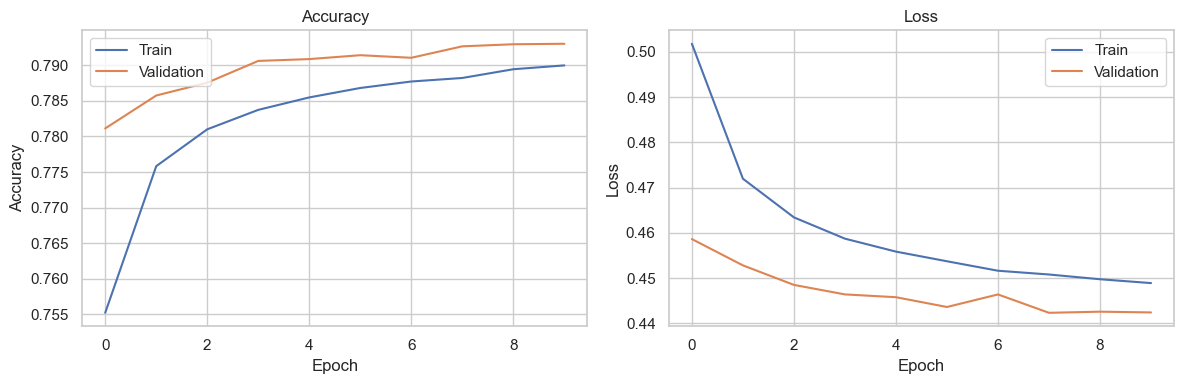


Résultats pour BiLSTM avec GloVe:
Accuracy: 0.7927
Precision: 0.7907
Recall: 0.7961
F1-score: 0.7934
Temps d'entraînement: 23881.10 secondes


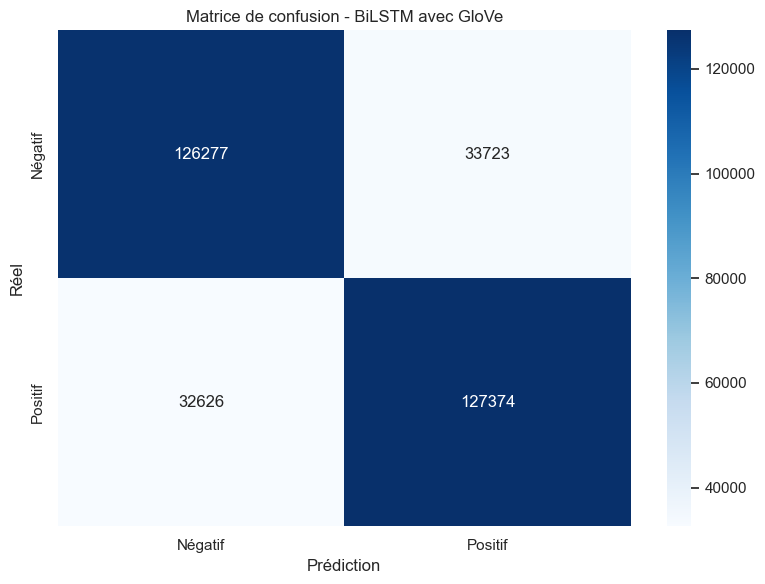

Epoch 1/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 184s 12ms/step - accuracy: 0.7294 - loss: 0.5366 - val_accuracy: 0.7658 - val_loss: 0.4821 - learning_rate: 0.0010
Epoch 2/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 177s 12ms/step - accuracy: 0.7652 - loss: 0.4890 - val_accuracy: 0.7687 - val_loss: 0.4780 - learning_rate: 0.0010
Epoch 3/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 169s 11ms/step - accuracy: 0.7729 - loss: 0.4755 - val_accuracy: 0.7746 - val_loss: 0.4684 - learning_rate: 0.0010
Epoch 4/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 171s 11ms/step - accuracy: 0.7784 - loss: 0.4670 - val_accuracy: 0.7759 - val_loss: 0.4684 - learning_rate: 0.0010
Epoch 5/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 171s 11ms/step - accuracy: 0.7823 - loss: 0.4614 - val_accuracy: 0.7768 - val_loss: 0.4691 - learning_rate: 0.0010
Epoch 6/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 172s 11ms/step - accuracy: 0.7833 - loss: 0.4578 - val_accuracy: 0.7768 - val_loss: 0.4703 - learning_rate: 0.0010
Epoch 7/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 17

2025/05/12 02:10:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/12 02:10:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


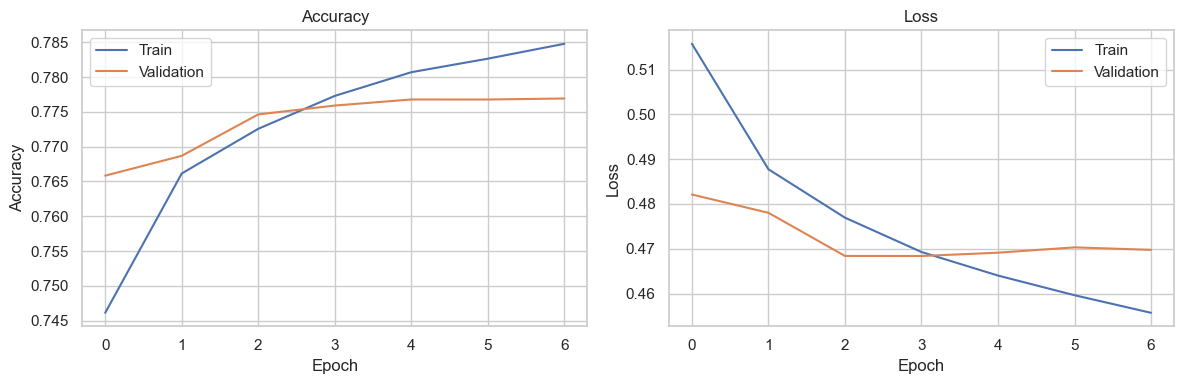


Résultats pour CNN avec GloVe:
Accuracy: 0.7759
Precision: 0.7678
Recall: 0.7910
F1-score: 0.7792
Temps d'entraînement: 1219.26 secondes


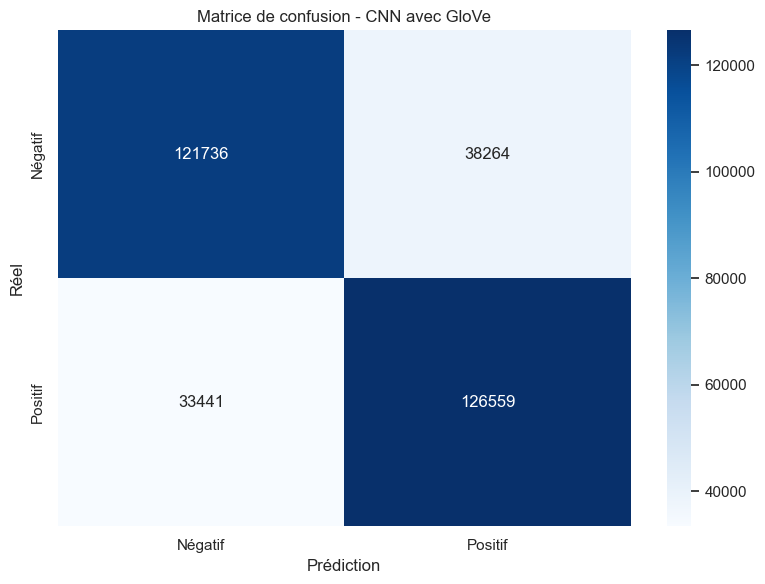

Epoch 1/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 253s 17ms/step - accuracy: 0.7009 - loss: 0.5697 - val_accuracy: 0.7343 - val_loss: 0.5278 - learning_rate: 0.0010
Epoch 2/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 238s 16ms/step - accuracy: 0.7320 - loss: 0.5310 - val_accuracy: 0.7376 - val_loss: 0.5213 - learning_rate: 0.0010
Epoch 3/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 275s 18ms/step - accuracy: 0.7383 - loss: 0.5224 - val_accuracy: 0.7398 - val_loss: 0.5179 - learning_rate: 0.0010
Epoch 4/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 296s 20ms/step - accuracy: 0.7426 - loss: 0.5171 - val_accuracy: 0.7369 - val_loss: 0.5202 - learning_rate: 0.0010
Epoch 5/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 300s 20ms/step - accuracy: 0.7452 - loss: 0.5127 - val_accuracy: 0.7405 - val_loss: 0.5166 - learning_rate: 0.0010
Epoch 6/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 305s 20ms/step - accuracy: 0.7482 - loss: 0.5089 - val_accuracy: 0.7422 - val_loss: 0.5151 - learning_rate: 0.0010
Epoch 7/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 30

2025/05/12 03:00:38 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/12 03:00:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


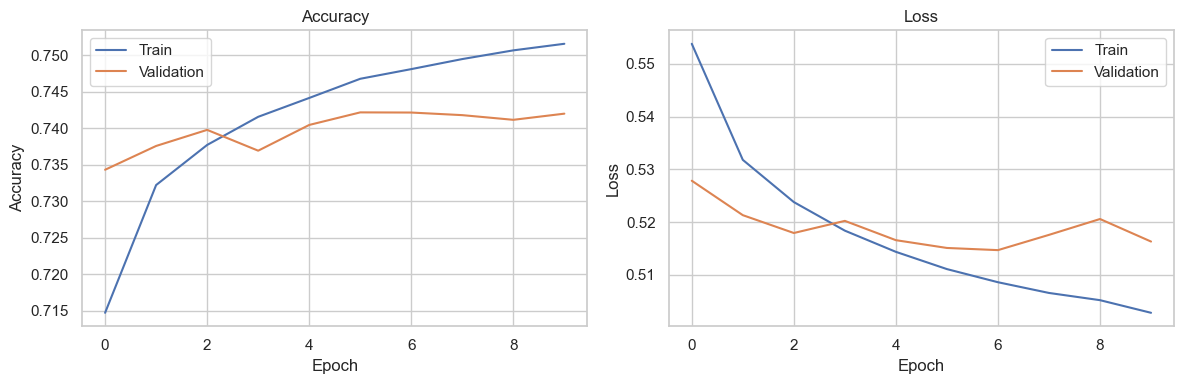


Résultats pour CNN-LSTM avec GloVe:
Accuracy: 0.7422
Precision: 0.7280
Recall: 0.7731
F1-score: 0.7499
Temps d'entraînement: 2901.08 secondes


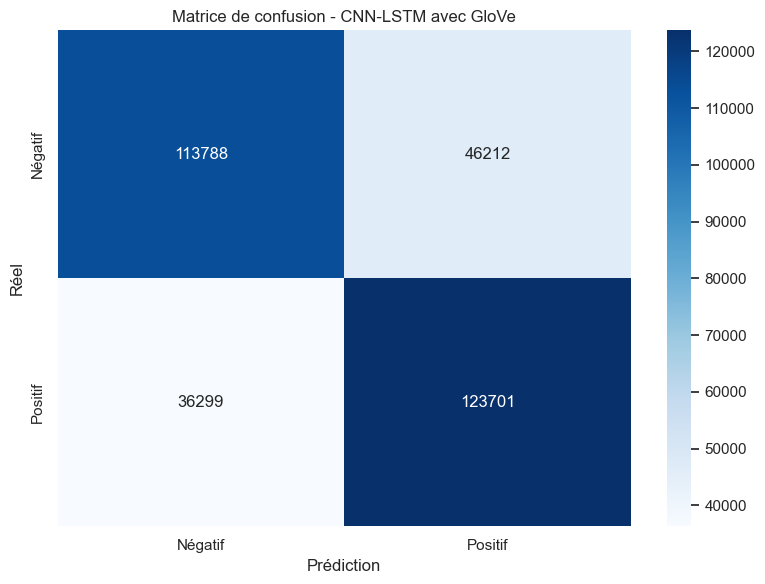

In [11]:
# Modèles avec GloVe
print("Entraînement des modèles avec GloVe...")

# LSTM bidirectionnel avec GloVe
bilstm_glove = create_bidirectional_lstm(embedding_matrix_glove, embedding_dim_glove, MAX_SEQUENCE_LENGTH)
bilstm_glove_results = train_and_evaluate_model(bilstm_glove, "GloVe", "BiLSTM", 
                                              X_train_padded, y_train, X_val_padded, y_val)

# CNN avec GloVe
cnn_glove = create_cnn(embedding_matrix_glove, embedding_dim_glove, MAX_SEQUENCE_LENGTH)
cnn_glove_results = train_and_evaluate_model(cnn_glove, "GloVe", "CNN", 
                                           X_train_padded, y_train, X_val_padded, y_val)

# Hybride CNN-LSTM avec GloVe
cnn_lstm_glove = create_cnn_lstm(embedding_matrix_glove, embedding_dim_glove, MAX_SEQUENCE_LENGTH)
cnn_lstm_glove_results = train_and_evaluate_model(cnn_lstm_glove, "GloVe", "CNN-LSTM", 
                                                X_train_padded, y_train, X_val_padded, y_val)

### 6.3 Entraînement avec FastText

Entraînement des modèles avec FastText...
Epoch 1/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 3215s 214ms/step - accuracy: 0.7537 - loss: 0.5029 - val_accuracy: 0.7805 - val_loss: 0.4599 - learning_rate: 0.0010
Epoch 2/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 3048s 203ms/step - accuracy: 0.7750 - loss: 0.4714 - val_accuracy: 0.7846 - val_loss: 0.4534 - learning_rate: 0.0010
Epoch 3/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 3116s 208ms/step - accuracy: 0.7782 - loss: 0.4670 - val_accuracy: 0.7847 - val_loss: 0.4522 - learning_rate: 0.0010
Epoch 4/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 3195s 213ms/step - accuracy: 0.7804 - loss: 0.4631 - val_accuracy: 0.7865 - val_loss: 0.4502 - learning_rate: 0.0010
Epoch 5/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 3270s 218ms/step - accuracy: 0.7805 - loss: 0.4626 - val_accuracy: 0.7881 - val_loss: 0.4488 - learning_rate: 0.0010
Epoch 6/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 3390s 226ms/step - accuracy: 0.7824 - loss: 0.4607 - val_accuracy: 0.7884 - val_loss: 0.4476 - learning_rate:

2025/05/12 12:51:05 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/12 12:51:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


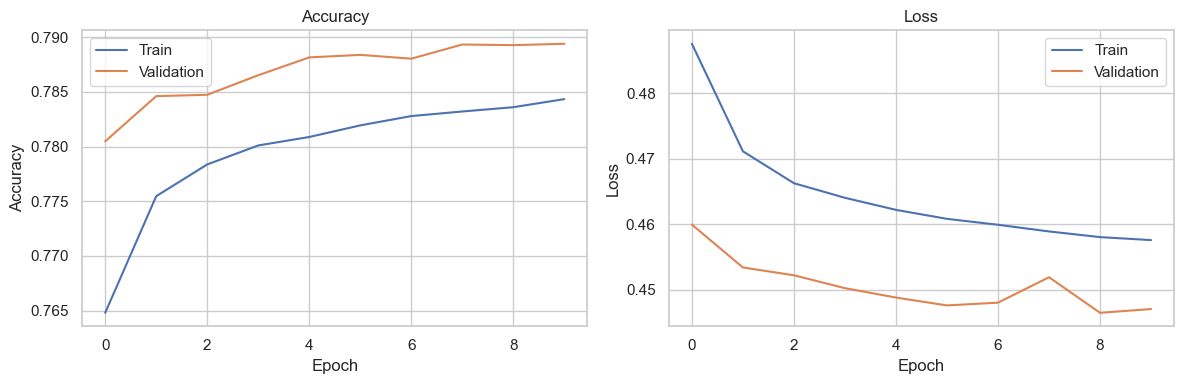


Résultats pour BiLSTM avec FastText:
Accuracy: 0.7893
Precision: 0.7806
Recall: 0.8046
F1-score: 0.7924
Temps d'entraînement: 34005.39 secondes


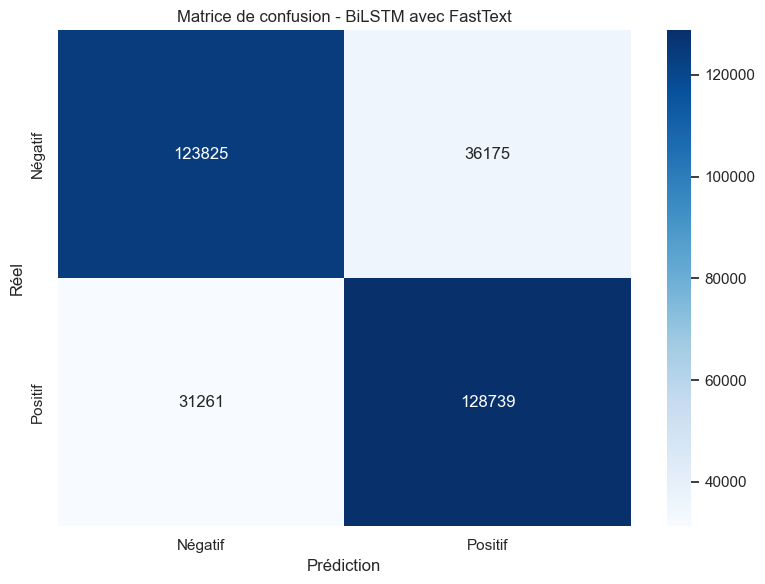

Epoch 1/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 209s 14ms/step - accuracy: 0.7358 - loss: 0.5322 - val_accuracy: 0.7681 - val_loss: 0.4805 - learning_rate: 0.0010
Epoch 2/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 198s 13ms/step - accuracy: 0.7629 - loss: 0.4944 - val_accuracy: 0.7728 - val_loss: 0.4740 - learning_rate: 0.0010
Epoch 3/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 200s 13ms/step - accuracy: 0.7678 - loss: 0.4872 - val_accuracy: 0.7739 - val_loss: 0.4700 - learning_rate: 0.0010
Epoch 4/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 196s 13ms/step - accuracy: 0.7721 - loss: 0.4798 - val_accuracy: 0.7760 - val_loss: 0.4685 - learning_rate: 0.0010
Epoch 5/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 195s 13ms/step - accuracy: 0.7736 - loss: 0.4776 - val_accuracy: 0.7768 - val_loss: 0.4663 - learning_rate: 0.0010
Epoch 6/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 197s 13ms/step - accuracy: 0.7748 - loss: 0.4749 - val_accuracy: 0.7776 - val_loss: 0.4698 - learning_rate: 0.0010
Epoch 7/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 19

2025/05/12 13:24:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/12 13:24:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


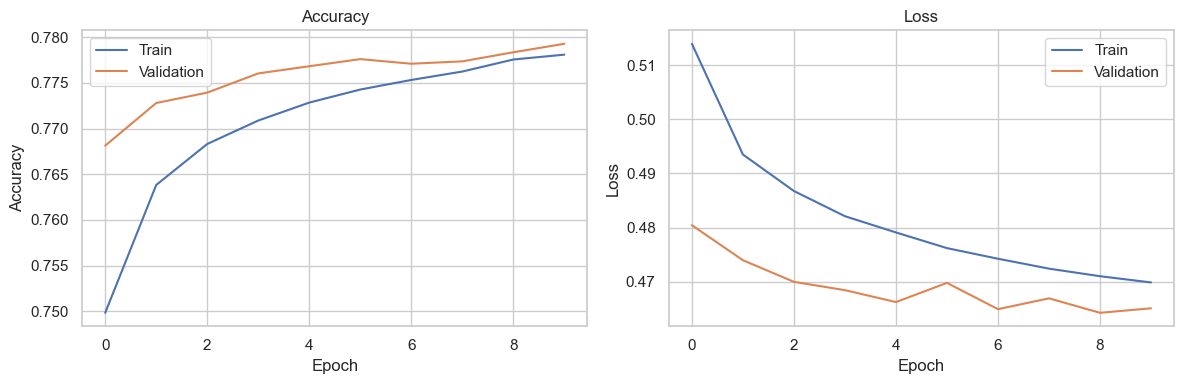


Résultats pour CNN avec FastText:
Accuracy: 0.7783
Precision: 0.7796
Recall: 0.7760
F1-score: 0.7778
Temps d'entraînement: 1995.41 secondes


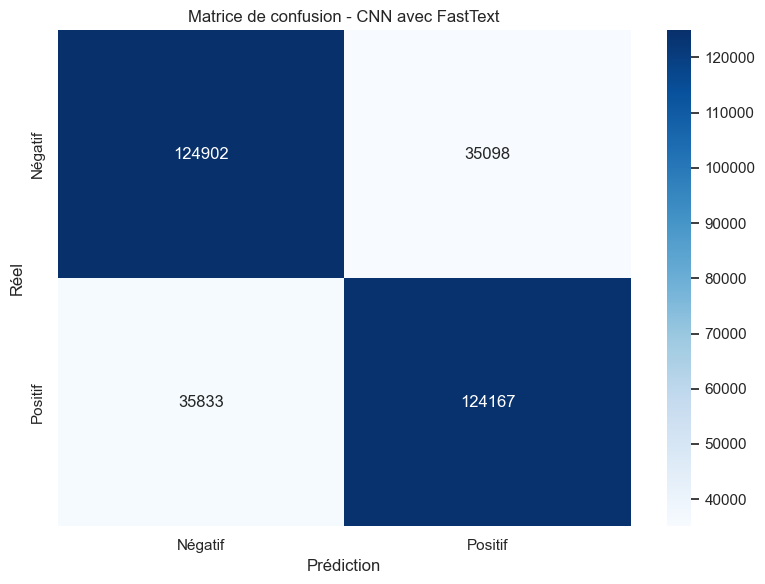

Epoch 1/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 425s 28ms/step - accuracy: 0.7116 - loss: 0.5590 - val_accuracy: 0.7336 - val_loss: 0.5254 - learning_rate: 0.0010
Epoch 2/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 379s 25ms/step - accuracy: 0.7297 - loss: 0.5351 - val_accuracy: 0.7334 - val_loss: 0.5263 - learning_rate: 0.0010
Epoch 3/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 383s 26ms/step - accuracy: 0.7320 - loss: 0.5319 - val_accuracy: 0.7365 - val_loss: 0.5207 - learning_rate: 0.0010
Epoch 4/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 379s 25ms/step - accuracy: 0.7344 - loss: 0.5284 - val_accuracy: 0.7369 - val_loss: 0.5195 - learning_rate: 0.0010
Epoch 5/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 381s 25ms/step - accuracy: 0.7357 - loss: 0.5267 - val_accuracy: 0.7378 - val_loss: 0.5182 - learning_rate: 0.0010
Epoch 6/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 383s 26ms/step - accuracy: 0.7373 - loss: 0.5247 - val_accuracy: 0.7344 - val_loss: 0.5231 - learning_rate: 0.0010
Epoch 7/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 38

2025/05/12 14:31:50 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/12 14:31:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


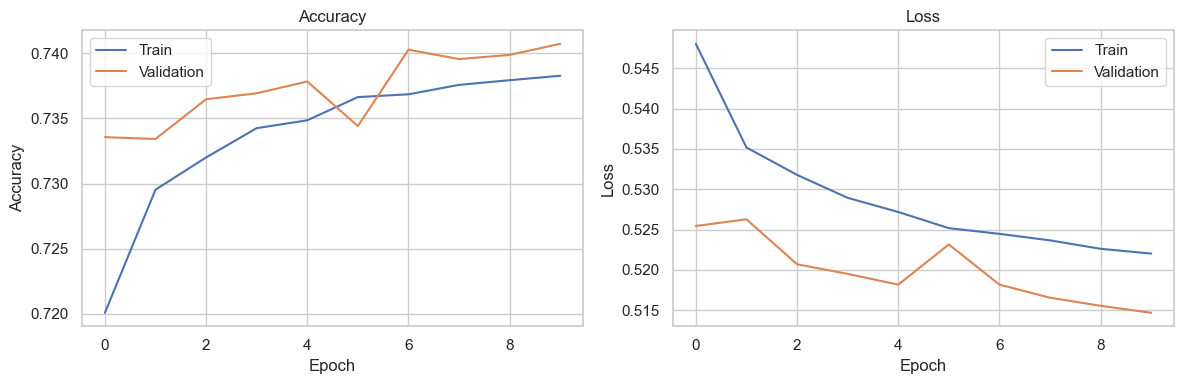


Résultats pour CNN-LSTM avec FastText:
Accuracy: 0.7407
Precision: 0.7281
Recall: 0.7685
F1-score: 0.7477
Temps d'entraînement: 3908.70 secondes


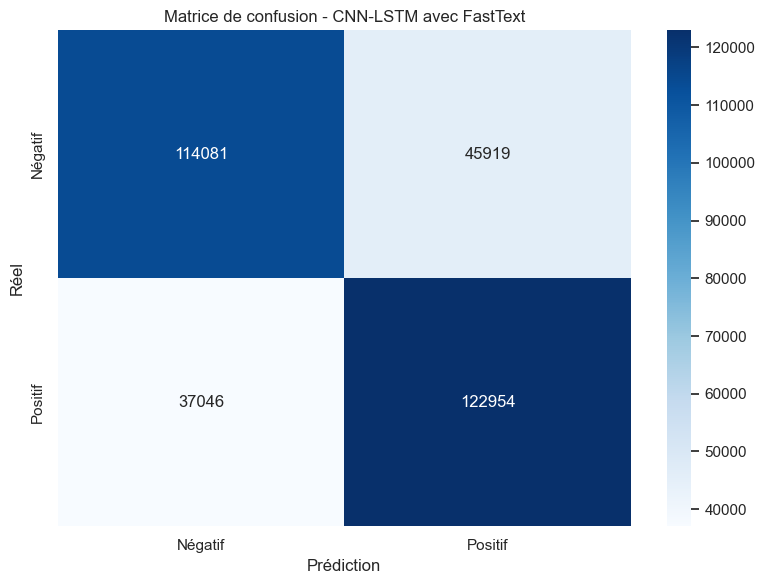

In [12]:
# Modèles avec FastText
print("Entraînement des modèles avec FastText...")

# LSTM bidirectionnel avec FastText
bilstm_ft = create_bidirectional_lstm(embedding_matrix_ft, embedding_dim_ft, MAX_SEQUENCE_LENGTH)
bilstm_ft_results = train_and_evaluate_model(bilstm_ft, "FastText", "BiLSTM", 
                                           X_train_padded, y_train, X_val_padded, y_val)

# CNN avec FastText
cnn_ft = create_cnn(embedding_matrix_ft, embedding_dim_ft, MAX_SEQUENCE_LENGTH)
cnn_ft_results = train_and_evaluate_model(cnn_ft, "FastText", "CNN", 
                                        X_train_padded, y_train, X_val_padded, y_val)

# Hybride CNN-LSTM avec FastText
cnn_lstm_ft = create_cnn_lstm(embedding_matrix_ft, embedding_dim_ft, MAX_SEQUENCE_LENGTH)
cnn_lstm_ft_results = train_and_evaluate_model(cnn_lstm_ft, "FastText", "CNN-LSTM", 
                                             X_train_padded, y_train, X_val_padded, y_val)

## 7. Comparaison des modèles

Comparaison des performances des modèles:


,Architecture,Embedding,Accuracy,Precision,Recall,F1-score,Training Time (s)
0,BiLSTM,Word2Vec,0.795794,0.791861,0.802531,0.797160,15617.666377
3,BiLSTM,GloVe,0.792659,0.790666,0.796087,0.793368,23881.101048
6,BiLSTM,FastText,0.789262,0.780643,0.804619,0.792450,34005.393502
1,CNN,Word2Vec,0.783225,0.779208,0.790419,0.784773,1266.048744
4,CNN,GloVe,0.775922,0.767848,0.790994,0.779249,1219.262080
7,CNN,FastText,0.778341,0.779625,0.776044,0.777830,1995.407120
2,CNN-LSTM,Word2Vec,0.747056,0.734585,0.773637,0.753606,1926.329370
5,CNN-LSTM,GloVe,0.742153,0.728026,0.773131,0.749901,2901.083550
8,CNN-LSTM,FastText,0.740734,0.728086,0.768463,0.747729,3908.697392


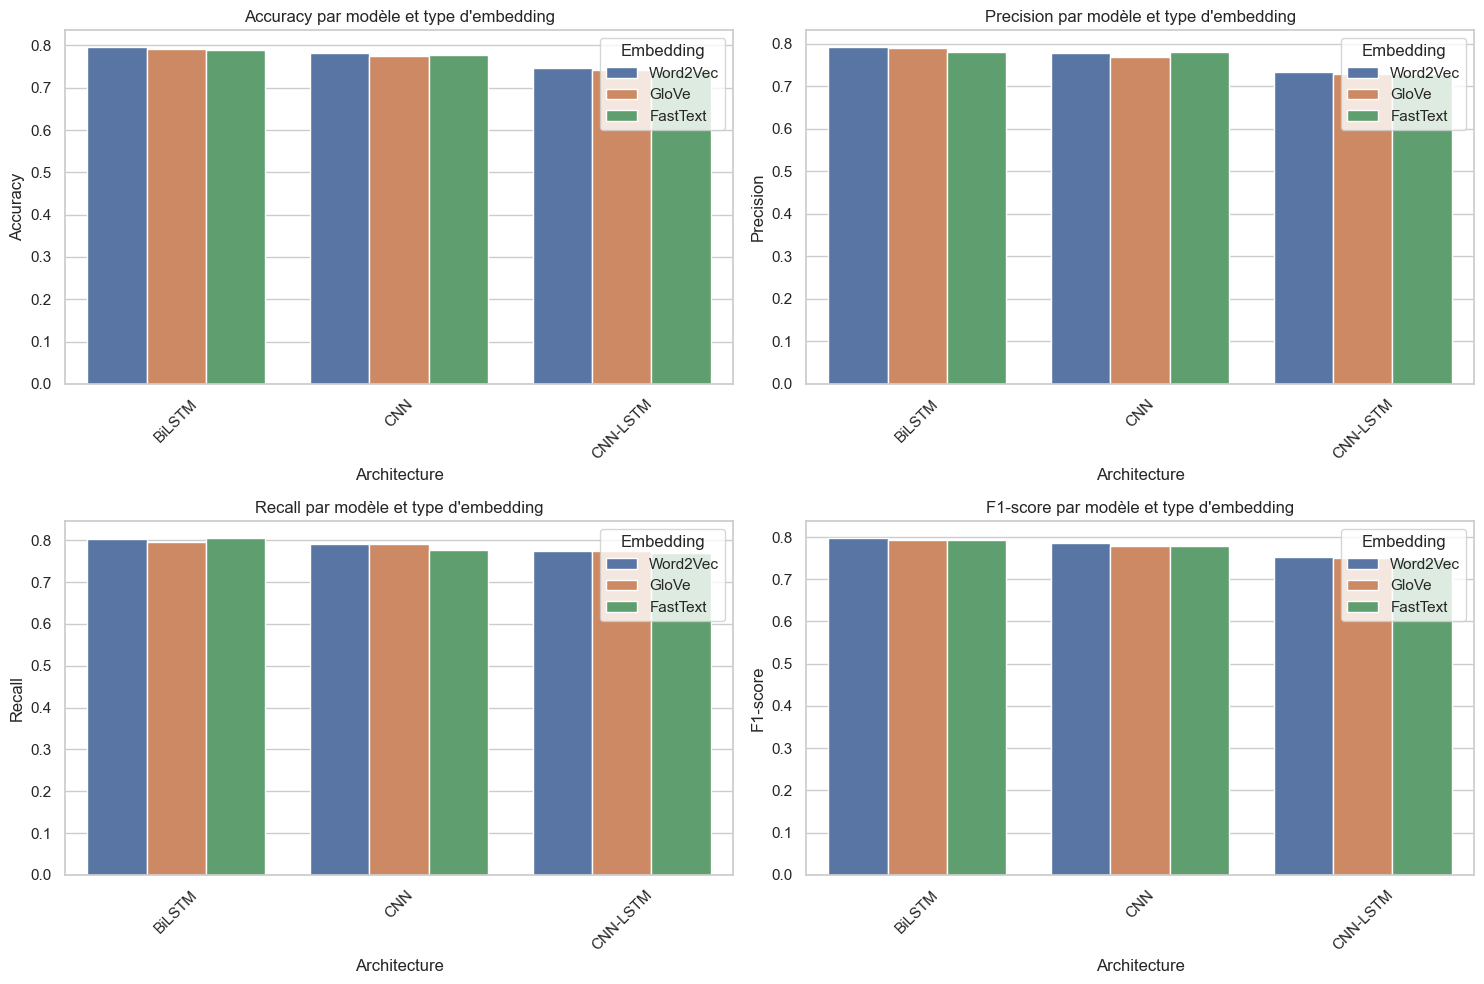

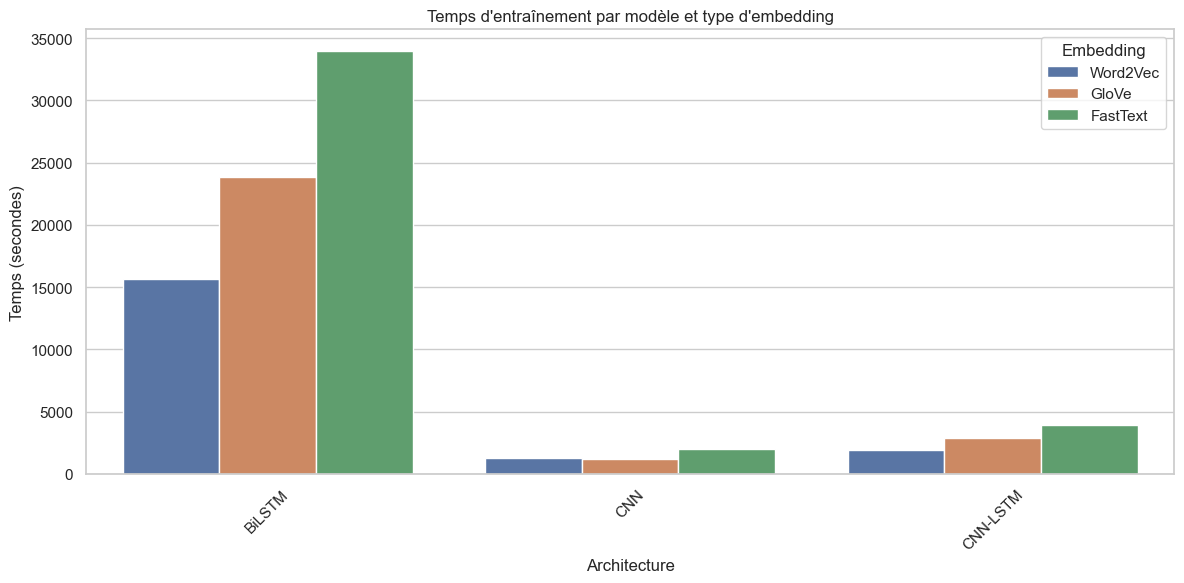

In [13]:
# Collecte des résultats
results = [
    bilstm_w2v_results, cnn_w2v_results, cnn_lstm_w2v_results,
    bilstm_glove_results, cnn_glove_results, cnn_lstm_glove_results,
    bilstm_ft_results, cnn_ft_results, cnn_lstm_ft_results
]

# Création d'un DataFrame pour la comparaison
results_df = pd.DataFrame([
    {
        "Architecture": res["architecture"],
        "Embedding": res["embedding_type"],
        "Accuracy": res["val_accuracy"],
        "Precision": res["precision"],
        "Recall": res["recall"],
        "F1-score": res["f1"],
        "Training Time (s)": res["training_time"]
    }
    for res in results
])

# Affichage des résultats
print("Comparaison des performances des modèles:")
display(results_df.sort_values(by='F1-score', ascending=False))

# Visualisation des performances
plt.figure(figsize=(15, 10))

# Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Architecture', y='Accuracy', hue='Embedding', data=results_df)
plt.title('Accuracy par modèle et type d\'embedding')
plt.xlabel('Architecture')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Precision
plt.subplot(2, 2, 2)
sns.barplot(x='Architecture', y='Precision', hue='Embedding', data=results_df)
plt.title('Precision par modèle et type d\'embedding')
plt.xlabel('Architecture')
plt.ylabel('Precision')
plt.xticks(rotation=45)

# Recall
plt.subplot(2, 2, 3)
sns.barplot(x='Architecture', y='Recall', hue='Embedding', data=results_df)
plt.title('Recall par modèle et type d\'embedding')
plt.xlabel('Architecture')
plt.ylabel('Recall')
plt.xticks(rotation=45)

# F1-score
plt.subplot(2, 2, 4)
sns.barplot(x='Architecture', y='F1-score', hue='Embedding', data=results_df)
plt.title('F1-score par modèle et type d\'embedding')
plt.xlabel('Architecture')
plt.ylabel('F1-score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Temps d'entraînement
plt.figure(figsize=(12, 6))
sns.barplot(x='Architecture', y='Training Time (s)', hue='Embedding', data=results_df)
plt.title('Temps d\'entraînement par modèle et type d\'embedding')
plt.xlabel('Architecture')
plt.ylabel('Temps (secondes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 8. Optimisation du meilleur modèle

In [14]:
# Identification du meilleur modèle basé sur le F1-score
best_model_info = results_df.loc[results_df['F1-score'].idxmax()]
print(f"Meilleur modèle selon le F1-score:")
print(f"- Architecture: {best_model_info['Architecture']}")
print(f"- Embedding: {best_model_info['Embedding']}")
print(f"- F1-score: {best_model_info['F1-score']:.4f}")

# Sélection de l'embedding approprié
if best_model_info['Embedding'] == 'Word2Vec':
    embedding_matrix = embedding_matrix_w2v
    embedding_dim = embedding_dim_w2v
elif best_model_info['Embedding'] == 'GloVe':
    embedding_matrix = embedding_matrix_glove
    embedding_dim = embedding_dim_glove
else:  # FastText
    embedding_matrix = embedding_matrix_ft
    embedding_dim = embedding_dim_ft

# Création d'un modèle optimisé avec des hyperparamètres améliorés
def create_optimized_model(architecture, embedding_matrix, embedding_dim, max_sequence_length):
    if architecture == 'BiLSTM':
        model = keras.Sequential([
            layers.Embedding(
                input_dim=len(word_index) + 1,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=max_sequence_length,
                trainable=True  # Fine-tuning des embeddings
            ),
            layers.SpatialDropout1D(0.3),
            layers.Bidirectional(layers.LSTM(256, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3)),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(1, activation='sigmoid')
        ])
    elif architecture == 'CNN':
        model = keras.Sequential([
            layers.Embedding(
                input_dim=len(word_index) + 1,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=max_sequence_length,
                trainable=True
            ),
            layers.SpatialDropout1D(0.3),
            # Multiples filtres de convolution avec différentes tailles
            layers.Conv1D(128, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(3),
            layers.Conv1D(128, 4, activation='relu', padding='same'),
            layers.MaxPooling1D(3),
            layers.Conv1D(128, 5, activation='relu', padding='same'),
            layers.GlobalMaxPooling1D(),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(1, activation='sigmoid')
        ])
    else:  # CNN-LSTM
        model = keras.Sequential([
            layers.Embedding(
                input_dim=len(word_index) + 1,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=max_sequence_length,
                trainable=True
            ),
            layers.SpatialDropout1D(0.3),
            # Partie CNN
            layers.Conv1D(128, 5, activation='relu', padding='same'),
            layers.MaxPooling1D(5),
            layers.Conv1D(128, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(3),
            # Partie LSTM
            layers.Bidirectional(layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3)),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(1, activation='sigmoid')
        ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

Meilleur modèle selon le F1-score:
- Architecture: BiLSTM
- Embedding: Word2Vec
- F1-score: 0.7972


## 9. Sauvegarde du meilleur modèle et des résultats pour comparaison ultérieure


In [15]:
# Identifier le meilleur modèle basé sur le F1-score
best_model_idx = results_df['F1-score'].idxmax()
best_model_row = results_df.iloc[best_model_idx]
best_model_name = f"{best_model_row['Architecture']}_{best_model_row['Embedding']}"
print(f"Meilleur modèle à sauvegarder: {best_model_name}")

# Sélection du modèle correspondant
if best_model_row['Architecture'] == 'BiLSTM':
    if best_model_row['Embedding'] == 'Word2Vec':
        best_model = bilstm_w2v
    elif best_model_row['Embedding'] == 'GloVe':
        best_model = bilstm_glove
    else:  # FastText
        best_model = bilstm_ft
elif best_model_row['Architecture'] == 'CNN':
    if best_model_row['Embedding'] == 'Word2Vec':
        best_model = cnn_w2v
    elif best_model_row['Embedding'] == 'GloVe':
        best_model = cnn_glove
    else:  # FastText
        best_model = cnn_ft
else:  # CNN-LSTM
    if best_model_row['Embedding'] == 'Word2Vec':
        best_model = cnn_lstm_w2v
    elif best_model_row['Embedding'] == 'GloVe':
        best_model = cnn_lstm_glove
    else:  # FastText
        best_model = cnn_lstm_ft

# Création des dossiers si nécessaires
if not os.path.exists('models'):
    os.makedirs('models')

# Sauvegarde du modèle au format compatible avec tous les notebooks
print(f"Sauvegarde du modèle {best_model_name}...")
best_model.save(f'models/best_advanced_model_{best_model_name}.h5')

# Sauvegarde du tokenizer
print("Sauvegarde du tokenizer...")
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Sauvegarde de la configuration du modèle
model_config = {
    'model_name': best_model_name,
    'architecture': best_model_row['Architecture'],
    'embedding_type': best_model_row['Embedding'],
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'embedding_dim': embedding_dim_w2v  # Tous les embeddings ont la même dimension
}

with open('models/model_config.pickle', 'wb') as handle:
    pickle.dump(model_config, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Sauvegarde des résultats pour comparaison ultérieure avec BERT
# Évaluation sur le jeu de test
print("Évaluation du modèle sur le jeu de test...")
test_loss, test_accuracy = best_model.evaluate(X_test_padded, y_test, verbose=0)

# Prédictions
y_test_pred = (best_model.predict(X_test_padded) > 0.5).astype(int)

# Métriques de performance
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Sauvegarde des résultats pour comparaison
advanced_model_results = {
    'model_name': best_model_name,
    'accuracy': test_accuracy,
    'precision': test_precision,
    'recall': test_recall,
    'f1': test_f1
}

with open('models/advanced_model_results.pickle', 'wb') as handle:
    pickle.dump(advanced_model_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Résultats sauvegardés pour le modèle {best_model_name}:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")

# Fonction pour tester une prédiction avec le modèle sauvegardé
def predict_with_saved_model(tweet):
    # Prétraitement du tweet
    # (Cette partie devrait être identique au prétraitement dans l'API)
    processed_tweet = tweet.lower()
    processed_tweet = re.sub(r'@\w+', '', processed_tweet)
    processed_tweet = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', processed_tweet)
    processed_tweet = re.sub(r'#(\w+)', r'\1', processed_tweet)
    processed_tweet = re.sub(r'[^\w\s]', '', processed_tweet)
    processed_tweet = re.sub(r'\d+', '', processed_tweet)
    
    # Tokenisation et padding
    sequence = tokenizer.texts_to_sequences([processed_tweet])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Prédiction
    prediction = best_model.predict(padded_sequence)[0][0]
    sentiment = "Positif" if prediction > 0.5 else "Négatif"
    confidence = float(prediction) if prediction > 0.5 else float(1 - prediction)
    
    return {
        "tweet": tweet,
        "processed_tweet": processed_tweet,
        "sentiment": sentiment,
        "confidence": confidence
    }

# Test de la fonction avec quelques exemples
test_tweets = [
    "I love this airline, their service is amazing!",
    "This was the worst flight experience I've ever had.",
    "The flight attendants were helpful but the plane was delayed by 2 hours.",
    "Not sure if I'll fly with them again, it's complicated."
]

print("\nTest de prédiction avec le modèle sauvegardé:")
for tweet in test_tweets:
    result = predict_with_saved_model(tweet)
    print(f"\nTweet: {result['tweet']}")
    print(f"Sentiment prédit: {result['sentiment']}")
    print(f"Confiance: {result['confidence']:.4f}")
    print("-" * 80)

Meilleur modèle à sauvegarder: BiLSTM_Word2Vec
Sauvegarde du modèle BiLSTM_Word2Vec...
Sauvegarde du tokenizer...
Évaluation du modèle sur le jeu de test...
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 533s 53ms/step
Résultats sauvegardés pour le modèle BiLSTM_Word2Vec:
Accuracy: 0.7951
Precision: 0.7915
Recall: 0.8011
F1-score: 0.7963

Test de prédiction avec le modèle sauvegardé:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step

Tweet: I love this airline, their service is amazing!
Sentiment prédit: Positif
Confiance: 0.9638
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

Tweet: This was the worst flight experience I've ever had.
Sentiment prédit: Négatif
Confiance: 0.9833
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

Tweet: The flight attendants were helpful but the plane was delayed by 2 hours.
Sentiment prédit: Négatif
Confiance: 0.7332
----------------------